## Run KGC with LLM + Ontology

In [1]:
import os
import re
import sys
import json
import torch
import spacy
from pathlib import Path
from openai import OpenAI
from fuzzywuzzy import fuzz
from datetime import datetime
from dotenv import load_dotenv
import matplotlib.pyplot as plt
# from dataloc import directory_path
from collections import defaultdict

# sys.path.append(os.getcwd())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ! python -m spacy download en_core_web_sm
# ! pip install spacy
# Spacy
# nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

In [2]:
load_dotenv()
api_key = os.getenv("API_KEY")
URI = os.getenv("URI_neo4j")
USER = os.getenv("USER_neo4j")
PASSWORD = os.getenv("PASSWORD_neo4j")

In [3]:
import warnings
warnings.filterwarnings("ignore", message="Field .* has conflict with protected namespace")
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

#### Run LLM function (chatgpt)

In [4]:

# models:
#   - gpt-3.5-turbo
#   - gpt-4
#   - gpt-4-turbo
#   - gpt-4o-mini
def query(prompt, model='gpt-4o-mini', temperature=0):
    client = OpenAI(api_key=api_key)

    res = client.chat.completions.create(
            model=model,
            temperature=temperature,
            messages=[
            {"role": "user", "content": prompt}
            ])
    # print(prompt)
    # print('output is: ', res)
    return res


In [5]:
#load json file
with open('LLM_Ontologies/ontology/geo_ontology.json', 'r') as file:
    ontology = json.load(file)

print(ontology)

entities_list = []
ontology_entities = ""
for concept in ontology["concepts"]:
    ontology_entities += f"{concept["label"]}, "
    entities_list.append(concept["label"])


ontology_entities = ontology_entities[:-2]
print(ontology_entities)

relations_list = []
ontology_relations_list = []
ontology_relations = ""
for relation in ontology["relations"]:
    ontology_relations += f"{relation["label"]}{relation["domain"], relation["range"]}, "
    relations_list.append(relation["label"])
    ontology_relations_list.append(relation)
    print(f"{relation["label"]}{relation["domain"], relation["range"]}, ")

print(ontology_relations)

print("___________________________________________________________________________________________________________")

text = "Mapping and geochronology by the Geological Society of Australia (Arriens, 1971) reveal that the granitic rocks in the western part of the Yalgoo 1:250,000 map sheet are in the order of 2,800 to 3,000 Ma."
def ontology_prompt(text, ontology_entities, ontology_relations, entities):

    prompt= f"""Given the following ontology and sentences, please extract the triples from the sentence according to the relations in the ontology. In the output, only include the triples in the given output format.

context:
Ontology Entities: {ontology_entities}
Ontology Relations: {ontology_relations}

Example Sentence: The stratigraphy of the area includes the Triassic Sandstone, which is approximately 250 Ma old and contains quartz and feldspar.
Example Output:
hasAge(Sandstone (Rock), Triassic (GeologicalTimescale))
hasAge(Sandstone (Rock), 250 Ma (GeologicalTimescale))
contains(Sandstone (Rock), quartz (Mineral))
contains(Sandstone (Rock), feldspar (Mineral))

Now, using the following provided entities as a guide for which entities to find, extract triples for the sentence:
Provided entities:
{entities}

Test Sentence: {text}
Test Output:
    """

    return prompt

prompt = ontology_prompt(text, ontology_entities, ontology_relations, "yes")

print(prompt)

{'title': 'GeologicalSurveys Ontology', 'id': 'ont_geologicalsurveys', 'concepts': [{'qid': 'GeologicalTimescale', 'label': 'GeologicalTimescale'}, {'qid': 'Location', 'label': 'Location'}, {'qid': 'Mineral', 'label': 'Mineral'}, {'qid': 'OreDeposit', 'label': 'OreDeposit'}, {'qid': 'Rock', 'label': 'Rock'}, {'qid': 'Stratigraphy', 'label': 'Stratigraphy'}, {'qid': 'Date', 'label': 'Date'}], 'relations': [{'pid': 'contains', 'label': 'contains', 'domain': 'Rock', 'range': 'Mineral'}, {'pid': 'contains', 'label': 'contains', 'domain': 'Mineral', 'range': 'OreDeposit'}, {'pid': 'contains', 'label': 'contains', 'domain': 'Stratigraphy', 'range': 'Rock'}, {'pid': 'contains', 'label': 'contains', 'domain': 'Rock', 'range': 'Rock'}, {'pid': 'foundIn', 'label': 'foundIn', 'domain': 'Rock', 'range': 'Location'}, {'pid': 'foundIn', 'label': 'foundIn', 'domain': 'Mineral', 'range': 'Location'}, {'pid': 'foundIn', 'label': 'foundIn', 'domain': 'OreDeposit', 'range': 'Location'}, {'pid': 'foundIn'

In [6]:
convert_type = {"ROCK" : "Rock", "TIMESCALE" : "GeologicalTimescale", "MINERAL" : "Mineral", "LOCATION" : "Location", 
                "ORE_DEPOSIT": "OreDeposit", "STRAT": "Stratigraphy", "DATE": "Date"}

def get_entities(doc, iob_tags):
    entities = []
    current_entity = []
    current_tag = None
    for token, tag in zip(doc, iob_tags):
        if tag.startswith('B-'):
            if current_entity:
                # Save the previous entity before starting a new one
                entities.append((" ".join(current_entity), convert_type[current_tag]))
            # Start a new entity
            current_entity = [token]
            current_tag = tag.split('-')[1]  # Get the entity type (e.g., DATE, LOCATION)
        elif tag.startswith('I-') and current_tag == tag.split('-')[1]:
            # Continue the current entity
            current_entity.append(token)
        else:
            if current_entity:
                # If we reach an 'O' or unrelated tag, save the current entity
                entities.append((" ".join(current_entity), convert_type[current_tag]))
                current_entity = []
                current_tag = None

    # Catch any remaining entity at the end of the loop
    if current_entity:
        entities.append((" ".join(current_entity), current_tag))

    return entities

In [7]:
# load json file
# with open("../Results/all_tags.json", "r") as file:
#     sall_tagged = json.load(file)

# # # load json file    REPLACE THIS LATER WITH THE FINAL TAG FILES
# with open("../Results/testing_tags.json", "r") as file:
#     all_tagged = json.load(file)

# load json file
with open("../Results/tagged_reports_combined_results.json", "r") as file:
    tagged_reports = json.load(file)

In [8]:
count = {"B-ROCK": 0, "I-ROCK": 0, "B-LOCATION": 0, "I-LOCATION": 0, "B-TIMESCALE": 0, "I-TIMESCALE": 0, "B-MINERAL": 0, "I-MINERAL": 0, 
         "B-ORE_DEPOSIT": 0, "I-ORE_DEPOSIT": 0, "B-STRAT": 0, "I-STRAT":0, "B-DATE" :0 , "I-DATE": 0}
num_of_sentences = 0
errors = 0
for report in tagged_reports:
    for a in tagged_reports[report]:
        num_of_sentences += 1
        tag = tagged_reports[report][a]["combined"].split()
        for s in tag:
            if 'O' != s:
                try:
                    count[s] += 1
                except:
                    print(s)
                    errors += 1

print(count)
print(errors)
print(num_of_sentences)

{'B-ROCK': 2837, 'I-ROCK': 627, 'B-LOCATION': 3783, 'I-LOCATION': 2071, 'B-TIMESCALE': 340, 'I-TIMESCALE': 91, 'B-MINERAL': 2607, 'I-MINERAL': 23, 'B-ORE_DEPOSIT': 410, 'I-ORE_DEPOSIT': 241, 'B-STRAT': 856, 'I-STRAT': 1071, 'B-DATE': 3137, 'I-DATE': 2110}
0
9447


In [9]:
for a in tagged_reports:
    for b in tagged_reports[a]:
        # print(all_tagged[a][b])
        tag = tagged_reports[a][b]["combined"]
        if "The latter" in b:
            print(tagged_reports[a][b])
            s = tagged_reports[a][b]["combined"].split()
            for c, word in enumerate(tagged_reports[a][b]["preprocess"].split()):
                print(word, s[c])


{'combined': 'O O O O O O O B-TIMESCALE I-TIMESCALE O O B-ROCK O O B-ROCK O O O B-STRAT I-STRAT I-STRAT O', 'preprocess': 'The latter comprises primarily low - grades ~1,700 Ma meta - conglomerates and coarse metasandstones , overlying the Mount Morrissey Metamorphics .'}
The O
latter O
comprises O
primarily O
low O
- O
grades O
~1,700 B-TIMESCALE
Ma I-TIMESCALE
meta O
- O
conglomerates B-ROCK
and O
coarse O
metasandstones B-ROCK
, O
overlying O
the O
Mount B-STRAT
Morrissey I-STRAT
Metamorphics I-STRAT
. O
{'combined': 'O O O O O O O O O O O O', 'preprocess': 'The latter two anomalies are associated with weathered sulphidic acid volcanics .'}
The O
latter O
two O
anomalies O
are O
associated O
with O
weathered O
sulphidic O
acid O
volcanics O
. O
{'combined': 'O O O O O O O O O O O O', 'preprocess': 'The latter were used for metallurgical tests and bulk density determinations .'}
The O
latter O
were O
used O
for O
metallurgical O
tests O
and O
bulk O
density O
determinations O
. O


In [10]:
def extract_temporal_relations(tagged_reports):
    for report in tagged_reports:
        for sentence in tagged_reports[report]:
            doc = tagged_reports[report][sentence]["preprocess"].split()
            print(sentence)
            iob_tags = tagged_reports[report][sentence]["combined"].split(" ")
            # print(iob_tags)
            # print(b)
            if len(set(iob_tags)) > 1:
                # if tagged_reports[a][b]["combined"][0] != 'error':
                entities = get_entities(doc, iob_tags)
                # print(entities)
                
                tagged_reports[report][sentence]["llm_results"] = None
                if entities:
                    entity_text = "\n".join([f"- {entity[0]} ({entity[1]})" for entity in entities])

                    prompt = ontology_prompt(sentence, ontology_entities, ontology_relations, entity_text)

                    results = query(prompt).choices[0].message.content.strip()
                    print(results)
                    tagged_reports[report][sentence]["llm_results"] = results
                print()
            else:
                # Text does not contain any entities
                tagged_reports[report][sentence]["llm_results"] = None
    return tagged_reports

# Perform relationship extraction
if not os.path.exists("../Results/tagged_reports_combined_results.json"):
    tagged_reports = extract_temporal_relations(tagged_reports)

In [11]:
# # save the results
# with open("../Results/LLM_Ontology_NER.json", "w") as file:
#     json.dump(tagged_reports, file)

# Load the results
with open("../Results/LLM_Ontology_NER.json", "r") as file:
    all_tagged = json.load(file)

In [12]:
# Function to extract entities and relation from the input string and convert to knowledge graph triple
def parse_and_convert_to_kg_types(input_string):
    # Regular expression to extract the relation, head entity, head type, tail entity, and tail type
    pattern = r'(\w+)\(([^()]+)\s\((\w+)\),\s([^()]+)\s\((\w+)\)\)'
    match = re.match(pattern, input_string)
    
    if match:
        relation = match.group(1)
        head_entity = match.group(2).strip()
        head_type = match.group(3)
        tail_entity = match.group(4).strip()
        tail_type = match.group(5)
        
        # Return the extracted data as a triple
        return (head_entity, head_type, relation, tail_entity, tail_type)
    else:
        return None
    
# Function to insert the triple into the knowledge graph
def add_to_knowledge_graph(kg, triple):
    head_entity, head_type, relation, tail_entity, tail_type = triple
    # Add the relation and tail entity to the knowledge graph
    kg[(head_entity, head_type)][relation].add((tail_entity, tail_type))


# Input string
input_string = "foundIn(Rainy RocksE2 (Rock), 18 April 2011 (Location))"

# Convert to knowledge graph triple
kg_triple = parse_and_convert_to_kg_types(input_string)

# Print the result
if kg_triple:
    print(f"({kg_triple[0]} ({kg_triple[1]}), {kg_triple[2]}, {kg_triple[3]} ({kg_triple[4]}))")
else:
    print("Invalid format")

(Rainy RocksE2 (Rock), foundIn, 18 April 2011 (Location))


### Clean KG with Ontology

In [13]:
# ontology_relation_concepts = {"ROCK": "Rock", "STRAT": "Stratigraphy", "LOCATION": "Location", "DATE": "Date", "MINERAL": "Mineral", "ORE_DEPOSIT": "OreDeposit", "TIMESCALE": "GeologicalTimescale"} # "GEO_TIME": "GeologicalTimescale", 
num_of_triples_llm = 0
num_of_cleaned_triples = 0

for reports in all_tagged:
    for sentence in all_tagged[reports]:
        all_tagged[reports][sentence]["ontology_cleaned"] = []
        if all_tagged[reports][sentence]["llm_results"]:
            triples = all_tagged[reports][sentence]["llm_results"].split("\n")
            # print(triples)
            for triple in triples:
                kg_triple = parse_and_convert_to_kg_types(triple)
                # print(kg_triple)
                # print(triple)
                if kg_triple:
                    num_of_triples_llm += 1
                    # print(f"({kg_triple[0]} ({kg_triple[1]}), {kg_triple[2]}, {kg_triple[3]} ({kg_triple[4]}))")
                    for relation in ontology_relations_list:
                        if (kg_triple[2] == relation["label"] and kg_triple[1] == relation["domain"] 
                            and kg_triple[4] == relation["range"] 
                            and not (kg_triple[0] == kg_triple[3] and kg_triple[1] == kg_triple[4])):
                            all_tagged[reports][sentence]["ontology_cleaned"].append(kg_triple)
                            num_of_cleaned_triples += 1

print(num_of_triples_llm)
print(num_of_cleaned_triples)

15610
10804


### Clean KG with NER Results
- If both entities in a relation is not in tagged in NER, then triple is removed

In [14]:
count = 0

for reports in all_tagged:
    for sentence in all_tagged[reports]:
        all_tagged[reports][sentence]["ner_cleaned"] = []
        if all_tagged[reports][sentence]["ontology_cleaned"]:

            iob_tags = all_tagged[reports][sentence]["combined"].split()
            text = all_tagged[reports][sentence]["preprocess"].split()
            entities = set(get_entities(text, iob_tags)) # Get unique entities

            triples = all_tagged[reports][sentence]["ontology_cleaned"]
            for triple in triples:
                left_entity_types = []
                left_entitys = []
                right_entity_types = []
                right_entitys = []
                
                # Get the entity types for the head and tail entities, can have multiple types
                for entity in entities:
                    if (entity[0] in triple[0]):
                        left_entity_types.append(entity[1])
                        left_entitys.append(entity[0])
                    if (entity[0] in triple[3]):
                        right_entity_types.append(entity[1])
                        right_entitys.append(entity[0])
                # If the entity types for the head entity are not consistent, set to None
                # if any of the entities have their types changed, change the relation
                change_relation = False
                temp_list = list(triple)

                # If the entity types are not consistent, set to None
                if len(set(left_entity_types)) > 1:
                    if triple[0] in left_entitys:
                        left_entity_types = [entity[1] for entity in entities if entity[0] == triple[0]]
                    elif triple[1] in left_entity_types:
                        left_entity_types = [triple[1]]
                    else:
                        left_entity_types = None
                elif len(set(left_entity_types)) == 1 and triple[1] != left_entity_types[0] and (triple[0] in left_entitys or triple[1] == "Date" or triple[1] == "Timescale"):
                    left_entity_types = [triple[1]]
                    change_relation = True

                if len(set(right_entity_types)) > 1:
                    # If the Entity is a Timescale and Rock, remove the Timescale from the Rock entity
                    # and add a new triple with the Timescale
                    if "GeologicalTimescale" in right_entity_types and ("Rock" in right_entity_types):
                        timescale_index = right_entity_types.index("GeologicalTimescale")
                        
                        temp_list[3] = triple[3].replace(right_entitys[timescale_index], "").strip()
                        temp_list[4] = ["Rock"]
                        timescale_triple = (triple[3], right_entity_types[0], "hasAge", right_entitys[timescale_index], "GeologicalTimescale")
                        all_tagged[reports][sentence]["ner_cleaned"].append(timescale_triple)
                elif len(set(right_entity_types)) == 1 and triple[4] != right_entity_types[0] and (triple[3] in right_entitys or triple[4] == "Date" or triple[4] == "Timescale"):
                    temp_list[4] = right_entity_types[0]
                    change_relation = True

                # If the entity types are not consistent, change it based on the ontology
                if change_relation:
                    for relation in ontology_relations_list:
                        if (temp_list[1] == relation["domain"] and temp_list[4] == relation["range"]):
                            temp_list[2] = relation["label"]
                            break
                        # If the relation is reversed, swap the entities and change the relation
                        elif (temp_list[1] == relation["range"] and temp_list[4] == relation["domain"]):
                            temp_list[2] = relation["label"]
                            temp_list[0], temp_list[3] = temp_list[3], temp_list[0]
                            temp_list[1], temp_list[4] = temp_list[4], temp_list[1]
                            break
                triple = tuple(temp_list)
                
                if left_entity_types and right_entity_types:
                    # head_entity, head_type, relation, tail_entity, tail_type = triple
                    # triple = (head_entity, head_type, relation, tail_entity, tail_type)
                    # print(triple)
                    all_tagged[reports][sentence]["ner_cleaned"].append(triple)
                    count += 1

print(count)

4659


In [15]:
# # save model json results
# import json
# with open('model_kg.json', 'w') as f:
#     json.dump(model_kg, f)

In [16]:
# load model json results
with open('model_kg.json', 'r') as f:
    model_kg = json.load(f)

print(len(model_kg))

2052


In [17]:
# # Temporal KG triples

# model_kg = [('Mango Bore Project', 'Location', 'foundIn', 'Gascoyne Junction', 'Location'), ('Mango Bore Project', 'Location', 'foundIn', 'Gascoyne Complex', 'Stratigraphy'), ('Gascoyne Junction', 'Location', 'LocatedIn', 'Gascoyne Complex', 'Location'), ('Wabli Creek', 'Location', 'LocatedIn', 'Wabli Creek project E09/1178', 'Location'), ('Wabli Creek', 'Location', 'hasCommonBoundaries', 'Wabli Creek project E09/1178', 'Location'), ('Mango Bore', 'Location', 'foundIn', 'Wajarri-Yamatji Claim', 'Location'), ('Wajarri-Yamatji Claim', 'Location', 'foundAt', '1st December 2005', 'Date'), ('Mango Bore', 'Location', 'foundIn', 'Gascoyne Complex', 'Stratigraphy'), ('Gascoyne Complex', 'Stratigraphy', 'foundIn', 'Capricorn', 'Location'), ('Gascoyne Complex', 'Stratigraphy', 'foundAt', '2007', 'Date'), ('Gascoyne Complex', 'Stratigraphy', 'limitedTo', 'Phanerozoic', 'Stratigraphy'), ('Gascoyne Complex', 'Stratigraphy', 'foundIn', 'Carnarvon basin', 'Location'), ('Phanerozoic', 'Stratigraphy', 'foundIn', 'Carnarvon basin', 'Location'), ('Sheppard', 'Location', 'LocatedIn', 'Sheppard', 'Location'), ('Glenburgh Orogeny', 'Rock', 'foundIn', 'Glenburgh', 'Location'), ('Glenburgh Orogeny', 'Rock', 'foundAt', '2005', 'Date'), ('Glenburgh Orogeny', 'Rock', 'foundAt', '1960', 'Date'), ('Morrissey Metamorphics', 'Stratigraphy', 'contains', 'metasedimentary rocks', 'Rock'), ('metasedimentary rocks', 'Rock', 'foundAt', '1830', 'Date'), ('metasedimentary rocks', 'Rock', 'foundAt', '1780', 'Date'), ('Capricorn Orogeny', 'Location', 'underlies', 'metasedimentary rocks', 'Rock'), ('Morrissey Metamorphics', 'Stratigraphy', 'foundAt', '2001', 'Date'), ('Morrissey Metamorphics', 'Stratigraphy', 'contains', 'zircons', 'Mineral'), ('Moorarie Supersuite', 'Stratigraphy', 'contains', 'granites', 'Rock'), ('Moorarie Supersuite', 'Stratigraphy', 'contains', 'monzogranite', 'Rock'), ('Moorarie Supersuite', 'Stratigraphy', 'contains', 'granodiorite', 'Rock'), ('Moorarie Supersuite', 'Stratigraphy', 'contains', 'syenogranite', 'Rock'), ('Moorarie Supersuite', 'Stratigraphy', 'contains', 'tonalite', 'Rock'), ('Moorarie Supersuite', 'Stratigraphy', 'contains', 'quartz diorite', 'Rock'), ('granites', 'Rock', 'foundIn', 'Morrissey Metamorphics', 'Location'), ('monzogranite', 'Rock', 'foundIn', 'Morrissey Metamorphics', 'Location'), ('granodiorite', 'Rock', 'foundIn', 'Morrissey Metamorphics', 'Location'), ('syenogranite', 'Rock', 'foundIn', 'Morrissey Metamorphics', 'Location'), ('tonalite', 'Rock', 'foundIn', 'Morrissey Metamorphics', 'Location'), ('quartz diorite', 'Rock', 'foundIn', 'Morrissey Metamorphics', 'Location'), ('Mangaroon Orogeny', 'Rock', 'hasAge', '1680 Ma', 'GeologicalTimescale'), ('Mangaroon Orogeny', 'Rock', 'hasAge', '1620 Ma', 'GeologicalTimescale'), ('Mangaroon Orogeny', 'Rock', 'foundIn', 'Mangaroon zone', 'Location'), ('Pooranoo Metamorphics', 'Stratigraphy', 'contains', 'metasedimentary rocks', 'Rock'), ('Mt James Formation', 'Stratigraphy', 'contains', 'rocks', 'Rock'), ('Pooranoo Metamorphics', 'Stratigraphy', 'foundAt', '1990', 'Date'), ('Mt James Formation', 'Stratigraphy', 'foundAt', '1990', 'Date'), ('Mount Morrissey Metamorphics', 'Stratigraphy', 'contains', 'meta-conglomerates', 'Rock'), ('Mount Morrissey Metamorphics', 'Stratigraphy', 'contains', 'metasandstones', 'Rock'), ('meta-conglomerates', 'Rock', 'overlies', 'Mount Morrissey Metamorphics', 'Stratigraphy'), ('metasandstones', 'Rock', 'overlies', 'Mount Morrissey Metamorphics', 'Stratigraphy'), ('metamorphic monazite', 'Rock', 'hasAge', '2007', 'Date'), ('xenotime', 'Mineral', 'hasAge', '2007', 'Date'), ('greenschist', 'Rock', 'contains', 'amphibolite', 'Rock'), ('greenschist', 'Rock', 'contains', 'pegmatite', 'Rock'), ('Morrissey Metamorphics', 'Stratigraphy', 'underlies', 'granitoids', 'Rock'), ('Morrissey Metamorphics', 'Stratigraphy', 'overlies', 'pegmatites', 'Rock'), ('calcrete', 'Rock', 'contains', 'uranium', 'OreDeposit'), ('calcrete', 'Rock', 'contains', 'uranium', 'OreDeposit'), ('Mount James Formation', 'Stratigraphy', 'hasAge', '1990', 'Date'), ('Mount James Formation', 'Stratigraphy', 'LocatedIn', 'Western Australia', 'Location'), ('Mount James Formation', 'Stratigraphy', 'foundIn', 'Western Australia', 'Location'), ('Gascoyne Complex', 'Stratigraphy', 'foundIn', 'Western Australia', 'Location'), ('Gascoyne Complex', 'Stratigraphy', 'foundIn', 'Perth', 'Location'), ('Gascoyne Complex', 'Stratigraphy', 'foundIn', 'Curtin University', 'Location'), ('Gascoyne Complex', 'Stratigraphy', 'contains', 'Morrissey Metamorphics', 'Stratigraphy'), ('Morrissey Metamorphics', 'Stratigraphy', 'underlies', 'orthogneiss', 'Rock'), ('orthogneiss', 'Rock', 'hasAge', 'Archaean', 'GeologicalTimescale'), ('calcrete', 'Rock', 'contains', 'uranium', 'OreDeposit'), ('calcrete', 'Rock', 'foundIn', 'Wabli Creek', 'Location'), ('uranium', 'OreDeposit', 'foundIn', 'Wabli Creek', 'Location'), ('Gascoyne Complex', 'Stratigraphy', 'belongsTo', 'Gascoyne Complex', 'Stratigraphy'), ('Gascoyne Complex', 'Stratigraphy', 'foundAt', '2007', 'Date')]

# print(model_kg)
# print(len(model_kg))

In [18]:
print(entities_list)
print(relations_list)
print(ontology_relations_list)

['GeologicalTimescale', 'Location', 'Mineral', 'OreDeposit', 'Rock', 'Stratigraphy', 'Date']
['contains', 'contains', 'contains', 'contains', 'foundIn', 'foundIn', 'foundIn', 'foundIn', 'foundAt', 'foundAt', 'foundAt', 'isPartOf', 'underlies', 'overlies', 'hasAge', 'hasAge', 'hasAge', 'hasAge', 'LocatedIn', 'locatedNear']
[{'pid': 'contains', 'label': 'contains', 'domain': 'Rock', 'range': 'Mineral'}, {'pid': 'contains', 'label': 'contains', 'domain': 'Mineral', 'range': 'OreDeposit'}, {'pid': 'contains', 'label': 'contains', 'domain': 'Stratigraphy', 'range': 'Rock'}, {'pid': 'contains', 'label': 'contains', 'domain': 'Rock', 'range': 'Rock'}, {'pid': 'foundIn', 'label': 'foundIn', 'domain': 'Rock', 'range': 'Location'}, {'pid': 'foundIn', 'label': 'foundIn', 'domain': 'Mineral', 'range': 'Location'}, {'pid': 'foundIn', 'label': 'foundIn', 'domain': 'OreDeposit', 'range': 'Location'}, {'pid': 'foundIn', 'label': 'foundIn', 'domain': 'Stratigraphy', 'range': 'Location'}, {'pid': 'found

#### Clean KG using Ontology

In [19]:
# ontology_relation_concepts = {"ROCK": "Rock", "STRAT": "Stratigraphy", "LOCATION": "Location", "DATE": "Date", "MINERAL": "Mineral", "ORE_DEPOSIT": "OreDeposit", "TIMESCALE": "GeologicalTimescale"} # "GEO_TIME": "GeologicalTimescale", 

# cleaned_model_kg = []
# for triples in model_kg:
#     # print(triples)
#     for relation in ontology_relations_list:
#         if triples[2] == relation["label"]:
#             # print(triples[2], relation["label"])
            
#             if ontology_relation_concepts[triples[1]] == relation["domain"] and ontology_relation_concepts[triples[4]] == relation["range"]:
#             # if triples[1] == relation["domain"] and triples[4] == relation["range"]:
#                 if triples not in cleaned_model_kg and not (triples[0] == triples[3] and triples[1] == triples[4]):
#                     # print(triples[1], relation["domain"], triples[4], relation["range"])
#                     cleaned_model_kg.append(triples)

# print(len(cleaned_model_kg))
# print(len(model_kg))


## Final KG Model

In [20]:
entity_type_conversion = {"Rock": "ROCK", "Stratigraphy": "STRAT", "Location": "LOCATION", "Date": "DATE", "Mineral": "MINERAL", "OreDeposit": "ORE_DEPOSIT", "GeologicalTimescale": "TIMESCALE"}
def convert_triple_format(triple):
    head_entity, head_type, relation, tail_entity, tail_type = triple
    head_type = entity_type_conversion[head_type]
    tail_type = entity_type_conversion[tail_type]
    converted_triple = (head_entity, head_type, relation, tail_entity, tail_type)
    return converted_triple

In [38]:
cleaned_model_kg = []
for report in all_tagged:
    for sentence in all_tagged[report]:
        if all_tagged[report][sentence]["ner_cleaned"]:
            for triple in all_tagged[report][sentence]["ner_cleaned"]:
                triple = convert_triple_format(triple)
                if not(triple[0] == triple[3]): #triple not in cleaned_model_kg and 
                    cleaned_model_kg.append(triple)
print(len(cleaned_model_kg))

4652


In [22]:


# for report in all_tagged:
#     date = 0
#     rock = 0
#     location = 0
#     mineral = 0
#     timescale = 0
#     ore_deposit = 0
#     strat = 0
#     for sentence in all_tagged[report]:
#         tagged = all_tagged[report][sentence]["combined"]
#         if "B-DATE" in tagged or "I-DATE" in tagged:
#             date += 1
#         if "B-ROCK" in tagged or "I-ROCK" in tagged:
#             rock += 1
#         if "B-LOCATION" in tagged or "I-LOCATION" in tagged:
#             location += 1
#         if "B-MINERAL" in tagged or "I-MINERAL" in tagged:
#             mineral += 1
#         if "B-TIMESCALE" in tagged or "I-TIMESCALE" in tagged:
#             timescale += 1
#         if "B-ORE_DEPOSIT" in tagged or "I-ORE_DEPOSIT" in tagged:
#             ore_deposit += 1
#         if "B-STRAT" in tagged or "I-STRAT" in tagged:
#             strat += 1
#     if date and rock and location and mineral and timescale and ore_deposit and strat:
#         print("All entities are present in the report:", report)
#         print(date, rock, location, mineral, timescale, ore_deposit, strat)

In [39]:
ontology_cleaned_only_kg = []
for report in all_tagged:
    for sentence in all_tagged[report]:
        if all_tagged[report][sentence]["ontology_cleaned"]:
            for triple in all_tagged[report][sentence]["ontology_cleaned"]:
                triple = convert_triple_format(triple)
                if not (triple[0] == triple[3]): #triple not in ontology_cleaned_only_kg and 
                    ontology_cleaned_only_kg.append(triple)

print(len(ontology_cleaned_only_kg))

10793


In [40]:
count = 0
for triples in ontology_cleaned_only_kg:
    if triples not in cleaned_model_kg:
        count += 1
        print(triples)

print(count)

('NiWest', 'ORE_DEPOSIT', 'foundAt', 'June 2007', 'DATE')
('NiWest', 'ORE_DEPOSIT', 'foundIn', 'Perth', 'LOCATION')
('Pleasant WA 6153', 'LOCATION', 'locatedNear', 'Perth', 'LOCATION')
('NiWest', 'ORE_DEPOSIT', 'hasAge', 'June 2007', 'TIMESCALE')
('haul road', 'ROCK', 'foundIn', 'Mount Burgess', 'LOCATION')
('project area', 'ROCK', 'foundIn', 'Mount Burgess', 'LOCATION')
('haul road', 'LOCATION', 'locatedNear', 'project area', 'LOCATION')
('ultramafic rocks', 'ROCK', 'foundIn', 'certain areas', 'LOCATION')
('silcrete', 'ROCK', 'foundIn', 'certain areas', 'LOCATION')
('laterite', 'ROCK', 'foundIn', 'certain areas', 'LOCATION')
('mulga', 'ROCK', 'contains', 'salt', 'MINERAL')
('mulga', 'ROCK', 'contains', 'mallee', 'ROCK')
('mulga', 'ROCK', 'contains', 'salt bush', 'ROCK')
('mulga', 'ROCK', 'contains', 'blue bush', 'ROCK')
('mulga', 'ROCK', 'contains', 'native pine', 'ROCK')
('mulga', 'ROCK', 'contains', 'sandalwood', 'ROCK')
('Soil sampling', 'ROCK', 'foundAt', 'June 2007 26', 'DATE')
(

### Evaluation

- Bar count - counts number of unique entity relations 

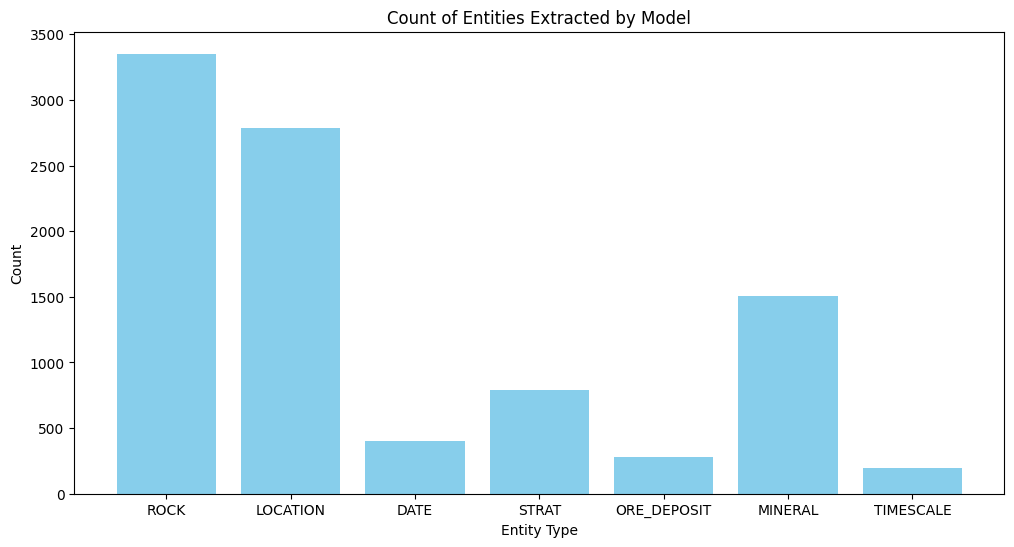

In [41]:
count_type = {"ROCK": 0, "LOCATION": 0, "DATE": 0, "STRAT": 0, "ORE_DEPOSIT": 0, "MINERAL": 0, "TIMESCALE": 0}


for triple in cleaned_model_kg:
    left_entity_type = triple[1].upper()
    right_entity_type = triple[4].upper()

    count_type[left_entity_type] += 1
    count_type[right_entity_type] += 1

entities_names = [entity for entity in count_type.keys()]
entities_values = [count for count in count_type.values()]

plt.figure(figsize=(12, 6))
plt.bar(entities_names, entities_values, color='skyblue')
plt.xlabel('Entity Type')
plt.ylabel('Count')
plt.title('Count of Entities Extracted by Model')
# plt.xticks(rotation=45)
plt.show()

In [42]:
from collections import Counter

# Example list of triples in format: (head, head_type, relation, tail, tail_type)
    
def count_relations(triples):
    # 1. Count unique (head, relation, tail) combinations per relation
    unique_relation_count = Counter(relation for head, _, relation, tail, _ in set(triples))

    # 2. Count non-unique relations (all occurrences, including duplicates)
    non_unique_relation_count = Counter(relation for head, _, relation, tail, _ in triples)

    # Output the results
    print("Unique relation counts:")
    for relation, count in unique_relation_count.items():
        print(f"{relation}: {count}")

    print("\nNon-unique relation counts (including duplicates):")
    for relation, count in non_unique_relation_count.items():
        print(f"{relation}: {count}")
    print()

print("Final Model KG cleaned with ontology and NER:")
count_relations(cleaned_model_kg)

print("Ontology cleaned only KG - Benchmark using our own defined ontoloy:")
count_relations(ontology_cleaned_only_kg)

Unique relation counts:
foundIn: 1209
locatedNear: 427
contains: 1559
LocatedIn: 248
foundAt: 358
hasAge: 167
isPartOf: 34
underlies: 27
overlies: 28

Non-unique relation counts (including duplicates):
locatedNear: 444
LocatedIn: 273
contains: 1889
foundIn: 1360
foundAt: 399
hasAge: 192
underlies: 29
isPartOf: 34
overlies: 32

Unique relation counts:
locatedNear: 821
LocatedIn: 346
foundIn: 3060
contains: 3395
foundAt: 1647
hasAge: 412
isPartOf: 48
overlies: 45
underlies: 44

Non-unique relation counts (including duplicates):
foundAt: 1809
foundIn: 3310
locatedNear: 845
hasAge: 439
LocatedIn: 379
contains: 3863
underlies: 46
isPartOf: 53
overlies: 49



In [43]:
entity_list = ["ROCK", "LOCATION", "GEO_TIME", "DATE", "STRAT", "ORE_DEPOSIT", "MINERAL", "TIMESCALE"]

### Visualise KG into Neo4J

In [44]:
from neo4j import GraphDatabase

def create_nodes(tx, nodes):
    create_cypher = ""
    for i, (name, type) in enumerate(nodes):
        create_cypher += f"CREATE (:{type} {{name: \"{name}\"}})\n"
    tx.run(create_cypher)

def create_edges(tx, edges):
    for edge in edges:
        name1, type1 = edge[0], edge[1]
        name2, type2 = edge[3], edge[4]
        relation = edge[2]
        tx.run(f"MATCH (a:{type1} {{name: \"{name1}\"}}), (b:{type2} {{name: \"{name2}\"}}) CREATE (a)-[:{relation}]->(b)")

def get_entities(triples):
    entities = []
    for triple in triples:
        entities.append((triple[0], triple[1]))
        entities.append((triple[3], triple[4]))
    return list(set(entities))

entity_kg = get_entities(cleaned_model_kg)

driver = GraphDatabase.driver(URI, auth=(USER, PASSWORD))
print(entity_kg)
print(len(entity_kg))

# Run the query to create the nodes and edges in the graph in Neo4j
with driver.session() as session:
    session.run("MATCH (n) DETACH DELETE n")
    create_nodes(session, entity_kg)
    create_edges(session, cleaned_model_kg)


# with driver.session() as session:
#     # create_cypher = ""
#     # for i, type in enumerate(entity_list):
#     #     create_cypher += f"CREATE (:{"ENTITY"} {{name: \"{type}\"}})\n"
#     # session.run(create_cypher)

#     for  relations in ontology_relations_list:
#         relation = relations["label"]
#         domain = relations["domain"]
#         range = relations["range"]
#         domains = []
#         ranges = []
#         for concepts in ontology_relation_concepts:
#             if ontology_relation_concepts[concepts] == domain:
#                 domains.append(concepts)
#             if ontology_relation_concepts[concepts] == range:
#                 ranges.append(concepts)
#         for d in domains:
#             for r in ranges:
#                 session.run(f"MATCH (a:ENTITY {{name: \"{d}\"}}), (b:ENTITY {{name: \"{r}\"}}) CREATE (a)-[:{relation}]->(b)")
#         # print(f"MATCH (a:ENTITY {{name: \"{domain}\"}}), (b:ENTITY {{name: \"{range}\"}}) CREATE (a)-[:{relation}]->(b)")
#         # session.run(f"MATCH (a:ENTITY {{name: \"{domain}\"}}), (b:ENTITY {{name: \"{range}\"}}) CREATE (a)-[:{relation}]->(b)")

# # print(ontology_relations_list)


[('kaolinitic clay', 'ROCK'), ('Bodies Ellendale 9', 'ORE_DEPOSIT'), ('Collier Group', 'STRAT'), ('vein gold', 'MINERAL'), ('tungsten', 'MINERAL'), ('1989', 'DATE'), ('goethite', 'MINERAL'), ('Magnetite', 'MINERAL'), ('Fortescue Basin', 'LOCATION'), ('quartzsericite', 'MINERAL'), ('Silicate', 'MINERAL'), ('Jackson', 'LOCATION'), ('Gossan', 'ROCK'), ('Samin Ltd.', 'LOCATION'), ('Doolena Gap', 'LOCATION'), ('Mid West Region', 'LOCATION'), ('evaluated', 'LOCATION'), ('kimberlite', 'ROCK'), ('A. victoriae', 'MINERAL'), ('Yarri Monzogranodiorite', 'STRAT'), ('Bangemall group rocks', 'ROCK'), ('arsenic anomaly', 'LOCATION'), ('Goongarrie', 'LOCATION'), ('BUTLER', 'LOCATION'), ('Marsh Bore', 'LOCATION'), ('coarse clastic rocks', 'ROCK'), ('Cu gossan', 'ROCK'), ('syenogranite', 'ROCK'), ('E52/1552-1556', 'LOCATION'), ('Gascoyne Tungsten', 'LOCATION'), ('Prairie Downs Fault', 'LOCATION'), ('British Hill', 'LOCATION'), ('Western Banded Ironstones', 'ROCK'), ('Granitic rocks', 'ROCK'), ('dolerite

### QA Rag

In [20]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from typing import Tuple, List, Optional
from langchain_core.pydantic_v1 import BaseModel, Field


# Extract entities from text
# https://neo4j.com/developer-blog/enhance-rag-knowledge-graph/
# https://github.com/tomasonjo/blogs/blob/master/llm/enhancing_rag_with_graph.ipynb
os.environ["OPENAI_API_KEY"] = api_key
llm=ChatOpenAI(temperature=0, model_name="gpt-4o-mini")
class Entities(BaseModel):
    """Identifying information about entities."""

    names: List[str] = Field(
        ...,
        description="All the person, organization, or business entities that "
        "appear in the text",
    )

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are extracting organization and person entities from the text.",
        ),
        (
            "human",
            "Use the given format to extract information from the following "
            "input: {question}",
        ),
    ]
)

entity_chain = prompt | llm.with_structured_output(Entities)

c:\Users\Peter\miniconda3\Lib\site-packages\IPython\core\interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [21]:
from neo4j import GraphDatabase
import openai

driver = GraphDatabase.driver(URI, auth=(USER,PASSWORD))

openai.api_key = api_key
client = OpenAI(api_key=api_key)

def run_query(query):
    with driver.session() as session:
        result = session.run(query)
        return [record for record in result]

def get_triples(keyword):
    query = f"""
        MATCH (n)-[r]->(m)
        WHERE n.name CONTAINS '{keyword}' OR m.name CONTAINS '{keyword}'
        RETURN n.name AS subject, type(r) AS predicate, m.name AS object
    """
    results = run_query(query)
    triples = [(record['subject'], record['predicate'], record['object']) for record in results]
    return triples

def query_llm(triples, question):
    # Format the triples as text for LLM input
    triples_text = "\n".join([f"{s} --{p}--> {o}" for s, p, o in triples])
    prompt = f"""Answer the question based only on the following context:
{triples_text}

Question: {question}
Use natural language and be concise.
Answer:"""
    

    # Send request to OpenAI LLM
    response = client.chat.completions.create(
        model='gpt-4o-mini',  # You can choose a different model
        temperature=0,
        messages=[
            {"role": "user", "content": prompt}
            ])
    
    answer = response.choices[0].message.content.strip()
    return answer

def QARag(question):
    # Extract keywords from the question (simple example)

    keywords = entity_chain.invoke({"question": question}).names
    print(keywords)
    # Get triples for each keyword
    all_triples = []
    for keyword in keywords:
        triples = get_triples(keyword)
        all_triples.extend(triples)
    print(all_triples)
    # Query LLM with the collected triples
    answer = query_llm(all_triples, question)
    print(f"Question: {question}")
    print(f"Answer: {answer}")


sample_question = "Where is clay and gold found in?"
QARag(sample_question)

# Close the driver
driver.close()


['clay', 'gold']
[('clay', 'foundIn', 'Mt Kilkenny'), ('clay', 'foundIn', 'Eucalyptus'), ('clay', 'foundIn', 'Hepi'), ('clay', 'contains', 'iron'), ('clay', 'contains', 'aluminium'), ('clay', 'contains', 'smectite'), ('plastic clay', 'contains', 'chlorite'), ('plastic clay', 'contains', 'kaolinite'), ('clays', 'foundIn', 'Eucalyptus Chrysoprase Pit'), ('clays', 'foundIn', 'Sullivan'), ('clays', 'contains', 'chrysoprase'), ('clays', 'contains', 'chlorite'), ('clays', 'contains', 'vanadium'), ('clays', 'contains', 'serpentine'), ('clays', 'contains', 'nickel'), ('clays', 'contains', 'magnesite'), ('clays', 'contains', 'smectite'), ('clays', 'contains', 'oxides'), ('clays', 'contains', 'manganese'), ('smectite clay', 'contains', 'nontronite'), ('bodies', 'contains', 'gold'), ('calcrete', 'contains', 'gold'), ('granodiorite', 'contains', 'gold'), ('quartz vein', 'contains', 'gold'), ('host rocks', 'contains', 'gold'), ('boudinaged quartz veins', 'contains', 'gold'), ('lag', 'contains', 'go